In [267]:
import pandas as pd
import seaborn as sns
import glob, os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Notes about DF
- `is_generated` : (bool) is the simulated tree, note when false, GED is just a single 0, not a dict
- `is_original_bt_espresso` : (bool) run with kevin's algo
- `num_unique_nodes` : (int) number of unique node types within the tree
- `total_nodes` : (int) total number of nodes within the generated tree
- `num_sub_trees` : (int) total number of sub trees within the generated tree
- `unique_node_freq` : (dict<string, int>) dictionary of unique node to how many in the tree
- `graph_edit_distance` : (Series[dict<string,Obj>]) series of scores for each sim tree
- GED Example:
```python
"graph_edit_distance": [
    {
        "sim_tree_num": 0,
        "num_nodes_in_subtree": 6,
        "num_uniq_nodes_in_subtree": 4,
        "unique_node_dict": {
            "Inverter": 0,
            "Repeater": 0,
            "LAT Sequence": 0,
            "Sequence": 1,
            "Parallel Selector": 1,
            "Selector": 0,
            "Parallel": 0,
            "Action": 3,
            "Condition": 1
        },
        "score": 8.0
    },
    {
        "sim_tree_num": 1,
        "num_nodes_in_subtree": 3,
        "num_uniq_nodes_in_subtree": 2,
        "unique_node_dict": {
            "Inverter": 0,
            "Repeater": 0,
            "LAT Sequence": 0,
            "Sequence": 1,
            "Parallel Selector": 0,
            "Selector": 0,
            "Parallel": 0,
            "Action": 2,
            "Condition": 0
        },
        "score": 1.0
    },
    {
        "sim_tree_num": 2,
        "num_nodes_in_subtree": 9,
        "num_uniq_nodes_in_subtree": 5,
        "unique_node_dict": {
            "Inverter": 0,
            "Repeater": 1,
            "LAT Sequence": 0,
            "Sequence": 0,
            "Parallel Selector": 1,
            "Selector": 1,
            "Parallel": 0,
            "Action": 3,
            "Condition": 3
        },
        "score": 15.0
    }
]
```

In [175]:
expr_num_key = "expr_num"
unique_node_freq_key = "unique_node_freq"
ged_key = "graph_edit_distance"
is_gen_key = "is_generated"
is_orig_key = "is_original_bt_espresso"
score_key = "score"
sim_tree_num_key = "sim_tree_num"
score_diff_key = "score_diff"
tot_nodes_key = "total_nodes"

In [168]:
def getNumFromExprFilename(filename):
    numeric_filter = filter(str.isdigit, filename)
    return "".join(numeric_filter)

def expandDictCol(col_name):
    return pd.concat([df.drop([col_name], axis=1), df[col_name].apply(pd.Series)], axis=1)

results_path = "results/"
results = []
gen_trees = []
df = None
p = None
for filename in glob.glob(results_path + "*.json"):
    expr_num = getNumFromExprFilename(filename)
    df = pd.read_json(filename).T
    df = expandDictCol(unique_node_freq_key)
    p =  df[df[is_gen_key] == False]
    p[expr_num_key] = expr_num
    gen_trees.append(p)
    df = df.drop(p.index)
    df = df.explode(ged_key)
    df = expandDictCol(ged_key)
    df[expr_num_key] = expr_num
    results.append(df)
    
f_df = pd.concat(results, axis=0, ignore_index=True)
s_df = pd.concat(gen_trees, axis=0, ignore_index=True)

/var/folders/bq/77cqsbrj0nnfyn947ttr9bxm0000gn/T/ipykernel_35881/4029955584.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[expr_num_key] = expr_num


In [372]:
len(s_df)

97

In [239]:
valid_score = f_df[score_key] >= 0

/var/folders/bq/77cqsbrj0nnfyn947ttr9bxm0000gn/T/ipykernel_35881/3741353502.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 5400x6000 with 0 Axes>

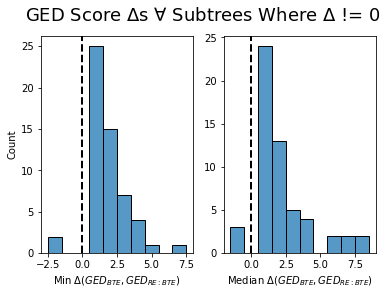

In [371]:
def makehm(index, axes, scored_df, is_discrete, new_title, fig):
    tmp_m = scored_df.unstack(level=1)
    # True = BT-Espresso
    # False = RE:BT-Espresso
    min_r = tmp_m[True] - tmp_m[False]
    min_r = min_r.reset_index()
    min_r = min_r.rename(columns={0 : score_diff_key})
    fminr = min_r[min_r[score_diff_key].round() != 0].round()
    ax3 = sns.histplot(fminr, x=score_diff_key, discrete=is_discrete, ax=axes[index])
    ax3.axvline(linewidth=2, color='#000000', linestyle='--')
    ax3.set_xlabel(new_title + r" $\Delta(GED_{BTE}, GED_{RE:BTE})$")
    if index != 0:
        ax3.set_ylabel("")
    #ax3.set_title(r"Difference in " + new_title +  r" GED Score $\forall$ Subtrees")


from matplotlib.pyplot import figure

figure(figsize=(18, 20), dpi=300)
tmp_m = f_df[valid_score].groupby([expr_num_key, is_orig_key, sim_tree_num_key])["score"]
plt.clf()
fig, axes = plt.subplots(1,2)
makehm(0, axes, tmp_m.min(), True, "Min", fig)
makehm(1, axes, tmp_m.median(), True, "Median", fig)
fig.suptitle(r"GED Score $\Delta$s $\forall$ Subtrees Where $\Delta$ != 0", fontsize=18)
fig.show()
